In [34]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [35]:
from keras import regularizers

In [36]:
import os

In [37]:
import librosa
from librosa import display

data, sampling_rate = librosa.load('E:\\8th sem\\Final_Year_Project_Files\\Audio_Speech_Actors_01-24\\Actor_01\\03-01-05-02-01-02-01.wav')

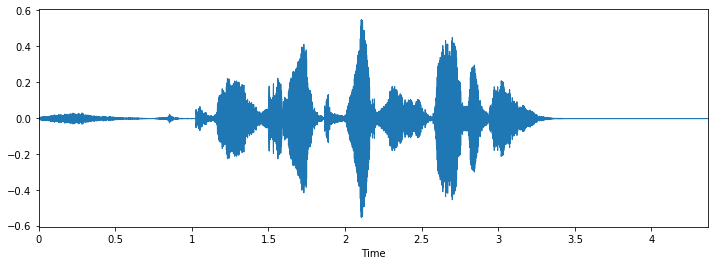

In [38]:
%matplotlib inline
import os
import pandas as pd
import glob 

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

C:\Users\Siddhant Mulajkar\Anaconda3\envs\sid\lib\site-packages\ipykernel_launcher.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  import sys


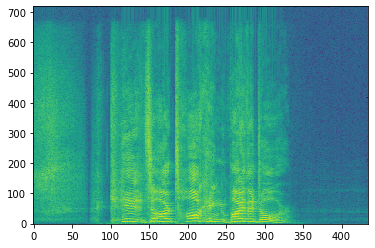

In [39]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('E:\\8th sem\\Final_Year_Project_Files\\Audio_Speech_Actors_01-24\\Actor_01\\03-01-05-02-01-02-01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

In [40]:
import time

path = 'E:\\8th sem\\Final_Year_Project_Files\\Audio_Speech_Actors_01-24\\Actor_01'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 2.525601387023926 seconds ---


In [41]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [42]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((60, 40), (60,))

In [43]:
# Saving joblib files to not load them again with the loop above

import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = 'E:\\8th sem\\Final_Year_Project_Files\\Saved_Models'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))


In [44]:
# Loading saved models

X = joblib.load('E:\\8th sem\\Final_Year_Project_Files\\Saved_Models\\X.joblib')
y = joblib.load('E:\\8th sem\\Final_Year_Project_Files\\Saved_Models\\y.joblib')

## Decision Tree Model

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=11)

In [46]:
from sklearn.tree import DecisionTreeClassifier

In [47]:
dtree = DecisionTreeClassifier()

In [48]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [49]:
predictions = dtree.predict(X_test)

In [50]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.33      0.33      0.33         3
           2       0.00      0.00      0.00         1
           3       1.00      0.33      0.50         3
           4       0.00      0.00      0.00         0
           5       0.50      0.25      0.33         4
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         4

    accuracy                           0.17        18
   macro avg       0.23      0.11      0.15        18
weighted avg       0.33      0.17      0.21        18



C:\Users\Siddhant Mulajkar\Anaconda3\envs\sid\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Siddhant Mulajkar\Anaconda3\envs\sid\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier


In [52]:
rforest = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 22000, random_state= 5)

In [53]:
rforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='log2', max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=22000,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

In [54]:
predictions = rforest.predict(X_test)

In [55]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.43      1.00      0.60         3
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         4

    accuracy                           0.17        18
   macro avg       0.05      0.12      0.07        18
weighted avg       0.07      0.17      0.10        18



C:\Users\Siddhant Mulajkar\Anaconda3\envs\sid\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Siddhant Mulajkar\Anaconda3\envs\sid\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [56]:
##Neural Network
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [57]:
x_traincnn.shape, x_testcnn.shape

((42, 40, 1), (18, 40, 1))

In [58]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras import backend as k
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
activation_3 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_4 (Activation)    (None, 5, 128)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 128)           

In [61]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [62]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

Train on 42 samples, validate on 18 samples
Epoch 1/1000
42/42 [==============================] - 2s 50ms/sample - loss: 16.8266 - accuracy: 0.1905 - val_loss: 17.0780 - val_accuracy: 0.1667
Epoch 2/1000
42/42 [==============================] - 0s 569us/sample - loss: 17.3586 - accuracy: 0.1190 - val_loss: 15.0258 - val_accuracy: 0.0000e+00
Epoch 3/1000
42/42 [==============================] - 0s 549us/sample - loss: 15.1622 - accuracy: 0.0476 - val_loss: 10.4946 - val_accuracy: 0.2222
Epoch 4/1000
42/42 [==============================] - 0s 570us/sample - loss: 10.9094 - accuracy: 0.0714 - val_loss: 6.6860 - val_accuracy: 0.1667
Epoch 5/1000
42/42 [==============================] - 0s 564us/sample - loss: 9.5741 - accuracy: 0.2143 - val_loss: 5.5836 - val_accuracy: 0.1667
Epoch 6/1000
42/42 [==============================] - 0s 522us/sample - loss: 7.9397 - accuracy: 0.1190 - val_loss: 4.3999 - val_accuracy: 0.1111
Epoch 7/1000
42/42 [==============================] - 0s 522us/sample 

42/42 [==============================] - 0s 522us/sample - loss: 1.3708 - accuracy: 0.5714 - val_loss: 1.2765 - val_accuracy: 0.6111
Epoch 57/1000
42/42 [==============================] - 0s 499us/sample - loss: 1.4338 - accuracy: 0.5000 - val_loss: 1.3468 - val_accuracy: 0.5556
Epoch 58/1000
42/42 [==============================] - 0s 522us/sample - loss: 1.4093 - accuracy: 0.5714 - val_loss: 1.6422 - val_accuracy: 0.3889
Epoch 59/1000
42/42 [==============================] - 0s 499us/sample - loss: 1.2424 - accuracy: 0.5476 - val_loss: 1.3783 - val_accuracy: 0.5556
Epoch 60/1000
42/42 [==============================] - 0s 476us/sample - loss: 1.3198 - accuracy: 0.5000 - val_loss: 1.3894 - val_accuracy: 0.2778
Epoch 61/1000
42/42 [==============================] - 0s 475us/sample - loss: 1.2352 - accuracy: 0.4762 - val_loss: 1.6174 - val_accuracy: 0.4444
Epoch 62/1000
42/42 [==============================] - 0s 522us/sample - loss: 1.1687 - accuracy: 0.6190 - val_loss: 1.5043 - val_ac

Epoch 112/1000
42/42 [==============================] - 0s 546us/sample - loss: 0.5981 - accuracy: 0.7857 - val_loss: 1.4287 - val_accuracy: 0.6111
Epoch 113/1000
42/42 [==============================] - 0s 492us/sample - loss: 0.5869 - accuracy: 0.7857 - val_loss: 1.3265 - val_accuracy: 0.6667
Epoch 114/1000
42/42 [==============================] - 0s 475us/sample - loss: 0.6628 - accuracy: 0.7143 - val_loss: 1.2668 - val_accuracy: 0.6111
Epoch 115/1000
42/42 [==============================] - 0s 547us/sample - loss: 0.5739 - accuracy: 0.8333 - val_loss: 1.2277 - val_accuracy: 0.6111
Epoch 116/1000
42/42 [==============================] - 0s 475us/sample - loss: 0.5122 - accuracy: 0.7619 - val_loss: 1.3263 - val_accuracy: 0.6111
Epoch 117/1000
42/42 [==============================] - 0s 488us/sample - loss: 0.5271 - accuracy: 0.8333 - val_loss: 1.4577 - val_accuracy: 0.6111
Epoch 118/1000
42/42 [==============================] - 0s 522us/sample - loss: 0.6416 - accuracy: 0.7619 - val_

42/42 [==============================] - 0s 499us/sample - loss: 0.2109 - accuracy: 0.9524 - val_loss: 1.2906 - val_accuracy: 0.6667
Epoch 168/1000
42/42 [==============================] - 0s 545us/sample - loss: 0.2772 - accuracy: 0.9524 - val_loss: 1.2159 - val_accuracy: 0.6667
Epoch 169/1000
42/42 [==============================] - 0s 522us/sample - loss: 0.2826 - accuracy: 0.9762 - val_loss: 1.3507 - val_accuracy: 0.6111
Epoch 170/1000
42/42 [==============================] - 0s 498us/sample - loss: 0.2746 - accuracy: 0.9048 - val_loss: 1.4001 - val_accuracy: 0.6667
Epoch 171/1000
42/42 [==============================] - 0s 546us/sample - loss: 0.2954 - accuracy: 0.9048 - val_loss: 1.3653 - val_accuracy: 0.6667
Epoch 172/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.2657 - accuracy: 0.9286 - val_loss: 1.4886 - val_accuracy: 0.7222
Epoch 173/1000
42/42 [==============================] - 0s 522us/sample - loss: 0.2520 - accuracy: 0.9286 - val_loss: 1.5264 - 

42/42 [==============================] - 0s 522us/sample - loss: 0.1779 - accuracy: 0.9286 - val_loss: 1.3852 - val_accuracy: 0.6667
Epoch 223/1000
42/42 [==============================] - 0s 519us/sample - loss: 0.1423 - accuracy: 0.9286 - val_loss: 1.5236 - val_accuracy: 0.6667
Epoch 224/1000
42/42 [==============================] - 0s 523us/sample - loss: 0.1498 - accuracy: 0.9524 - val_loss: 1.6143 - val_accuracy: 0.7222
Epoch 225/1000
42/42 [==============================] - 0s 505us/sample - loss: 0.1108 - accuracy: 0.9762 - val_loss: 1.5991 - val_accuracy: 0.7222
Epoch 226/1000
42/42 [==============================] - 0s 503us/sample - loss: 0.1224 - accuracy: 0.9762 - val_loss: 1.4466 - val_accuracy: 0.7222
Epoch 227/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.1121 - accuracy: 0.9762 - val_loss: 1.4024 - val_accuracy: 0.7222
Epoch 228/1000
42/42 [==============================] - 0s 475us/sample - loss: 0.1111 - accuracy: 1.0000 - val_loss: 1.4997 - 

42/42 [==============================] - 0s 499us/sample - loss: 0.1082 - accuracy: 0.9524 - val_loss: 1.6517 - val_accuracy: 0.7222
Epoch 278/1000
42/42 [==============================] - 0s 522us/sample - loss: 0.1558 - accuracy: 0.9286 - val_loss: 1.5854 - val_accuracy: 0.6667
Epoch 279/1000
42/42 [==============================] - 0s 490us/sample - loss: 0.1054 - accuracy: 0.9524 - val_loss: 1.5319 - val_accuracy: 0.7222
Epoch 280/1000
42/42 [==============================] - 0s 487us/sample - loss: 0.1254 - accuracy: 0.9762 - val_loss: 1.4912 - val_accuracy: 0.7222
Epoch 281/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.0600 - accuracy: 1.0000 - val_loss: 1.5421 - val_accuracy: 0.7222
Epoch 282/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.0776 - accuracy: 1.0000 - val_loss: 1.5047 - val_accuracy: 0.7222
Epoch 283/1000
42/42 [==============================] - 0s 498us/sample - loss: 0.0656 - accuracy: 1.0000 - val_loss: 1.5413 - 

42/42 [==============================] - 0s 522us/sample - loss: 0.0783 - accuracy: 0.9762 - val_loss: 1.4978 - val_accuracy: 0.7222
Epoch 333/1000
42/42 [==============================] - 0s 516us/sample - loss: 0.0659 - accuracy: 0.9762 - val_loss: 1.4622 - val_accuracy: 0.7222
Epoch 334/1000
42/42 [==============================] - 0s 498us/sample - loss: 0.0771 - accuracy: 0.9762 - val_loss: 1.4272 - val_accuracy: 0.7222
Epoch 335/1000
42/42 [==============================] - 0s 522us/sample - loss: 0.0563 - accuracy: 1.0000 - val_loss: 1.3124 - val_accuracy: 0.7222
Epoch 336/1000
42/42 [==============================] - 0s 477us/sample - loss: 0.0508 - accuracy: 1.0000 - val_loss: 1.3203 - val_accuracy: 0.6667
Epoch 337/1000
42/42 [==============================] - 0s 522us/sample - loss: 0.0658 - accuracy: 0.9762 - val_loss: 1.5193 - val_accuracy: 0.6667
Epoch 338/1000
42/42 [==============================] - 0s 522us/sample - loss: 0.0948 - accuracy: 0.9524 - val_loss: 1.6475 - 

42/42 [==============================] - 0s 499us/sample - loss: 0.0430 - accuracy: 1.0000 - val_loss: 1.5791 - val_accuracy: 0.7222
Epoch 388/1000
42/42 [==============================] - 0s 508us/sample - loss: 0.0408 - accuracy: 0.9762 - val_loss: 1.6045 - val_accuracy: 0.7222
Epoch 389/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.0507 - accuracy: 0.9762 - val_loss: 1.4142 - val_accuracy: 0.7222
Epoch 390/1000
42/42 [==============================] - 0s 498us/sample - loss: 0.0235 - accuracy: 1.0000 - val_loss: 1.3127 - val_accuracy: 0.6667
Epoch 391/1000
42/42 [==============================] - 0s 498us/sample - loss: 0.0620 - accuracy: 0.9762 - val_loss: 1.5154 - val_accuracy: 0.7222
Epoch 392/1000
42/42 [==============================] - 0s 521us/sample - loss: 0.0378 - accuracy: 1.0000 - val_loss: 1.7587 - val_accuracy: 0.7222
Epoch 393/1000
42/42 [==============================] - 0s 522us/sample - loss: 0.0374 - accuracy: 1.0000 - val_loss: 1.7443 - 

42/42 [==============================] - 0s 488us/sample - loss: 0.0178 - accuracy: 1.0000 - val_loss: 1.5701 - val_accuracy: 0.6667
Epoch 443/1000
42/42 [==============================] - 0s 522us/sample - loss: 0.0282 - accuracy: 1.0000 - val_loss: 1.5822 - val_accuracy: 0.6667
Epoch 444/1000
42/42 [==============================] - 0s 505us/sample - loss: 0.0256 - accuracy: 1.0000 - val_loss: 1.5911 - val_accuracy: 0.7222
Epoch 445/1000
42/42 [==============================] - 0s 496us/sample - loss: 0.0189 - accuracy: 1.0000 - val_loss: 1.6035 - val_accuracy: 0.7222
Epoch 446/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.0285 - accuracy: 1.0000 - val_loss: 1.6609 - val_accuracy: 0.7222
Epoch 447/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.0344 - accuracy: 1.0000 - val_loss: 1.6280 - val_accuracy: 0.7222
Epoch 448/1000
42/42 [==============================] - 0s 498us/sample - loss: 0.0186 - accuracy: 1.0000 - val_loss: 1.6016 - 

42/42 [==============================] - 0s 522us/sample - loss: 0.0090 - accuracy: 1.0000 - val_loss: 1.6707 - val_accuracy: 0.7222
Epoch 498/1000
42/42 [==============================] - 0s 523us/sample - loss: 0.0227 - accuracy: 1.0000 - val_loss: 1.6875 - val_accuracy: 0.7222
Epoch 499/1000
42/42 [==============================] - 0s 522us/sample - loss: 0.0245 - accuracy: 1.0000 - val_loss: 1.5153 - val_accuracy: 0.7222
Epoch 500/1000
42/42 [==============================] - 0s 522us/sample - loss: 0.0557 - accuracy: 0.9762 - val_loss: 1.5725 - val_accuracy: 0.7222
Epoch 501/1000
42/42 [==============================] - 0s 486us/sample - loss: 0.0142 - accuracy: 1.0000 - val_loss: 1.6536 - val_accuracy: 0.7222
Epoch 502/1000
42/42 [==============================] - 0s 516us/sample - loss: 0.0259 - accuracy: 1.0000 - val_loss: 1.6586 - val_accuracy: 0.7222
Epoch 503/1000
42/42 [==============================] - 0s 522us/sample - loss: 0.0341 - accuracy: 0.9762 - val_loss: 1.4828 - 

42/42 [==============================] - 0s 499us/sample - loss: 0.0170 - accuracy: 1.0000 - val_loss: 1.5129 - val_accuracy: 0.6667
Epoch 553/1000
42/42 [==============================] - 0s 522us/sample - loss: 0.0523 - accuracy: 0.9762 - val_loss: 1.3923 - val_accuracy: 0.6667
Epoch 554/1000
42/42 [==============================] - 0s 515us/sample - loss: 0.0127 - accuracy: 1.0000 - val_loss: 1.3206 - val_accuracy: 0.6667
Epoch 555/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.0129 - accuracy: 1.0000 - val_loss: 1.3077 - val_accuracy: 0.6667
Epoch 556/1000
42/42 [==============================] - 0s 522us/sample - loss: 0.0162 - accuracy: 1.0000 - val_loss: 1.4425 - val_accuracy: 0.7222
Epoch 557/1000
42/42 [==============================] - 0s 502us/sample - loss: 0.0073 - accuracy: 1.0000 - val_loss: 1.6287 - val_accuracy: 0.7222
Epoch 558/1000
42/42 [==============================] - 0s 498us/sample - loss: 0.0160 - accuracy: 1.0000 - val_loss: 1.7290 - 

42/42 [==============================] - 0s 494us/sample - loss: 0.0124 - accuracy: 1.0000 - val_loss: 1.6705 - val_accuracy: 0.7222
Epoch 608/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.0129 - accuracy: 1.0000 - val_loss: 1.5627 - val_accuracy: 0.7222
Epoch 609/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.0147 - accuracy: 1.0000 - val_loss: 1.5280 - val_accuracy: 0.7222
Epoch 610/1000
42/42 [==============================] - 0s 508us/sample - loss: 0.0318 - accuracy: 0.9762 - val_loss: 1.4541 - val_accuracy: 0.7222
Epoch 611/1000
42/42 [==============================] - 0s 522us/sample - loss: 0.0616 - accuracy: 0.9762 - val_loss: 1.5125 - val_accuracy: 0.6667
Epoch 612/1000
42/42 [==============================] - 0s 467us/sample - loss: 0.0537 - accuracy: 0.9524 - val_loss: 1.5743 - val_accuracy: 0.7222
Epoch 613/1000
42/42 [==============================] - 0s 494us/sample - loss: 0.0075 - accuracy: 1.0000 - val_loss: 1.4203 - 

42/42 [==============================] - 0s 522us/sample - loss: 0.0206 - accuracy: 1.0000 - val_loss: 1.5791 - val_accuracy: 0.7778
Epoch 663/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.8243 - val_accuracy: 0.7222
Epoch 664/1000
42/42 [==============================] - 0s 501us/sample - loss: 0.0180 - accuracy: 1.0000 - val_loss: 1.8792 - val_accuracy: 0.6667
Epoch 665/1000
42/42 [==============================] - 0s 474us/sample - loss: 0.0088 - accuracy: 1.0000 - val_loss: 1.5814 - val_accuracy: 0.6667
Epoch 666/1000
42/42 [==============================] - 0s 519us/sample - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.3163 - val_accuracy: 0.6667
Epoch 667/1000
42/42 [==============================] - 0s 522us/sample - loss: 0.0060 - accuracy: 1.0000 - val_loss: 1.1735 - val_accuracy: 0.6667
Epoch 668/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.1108 - 

42/42 [==============================] - 0s 495us/sample - loss: 0.0527 - accuracy: 0.9524 - val_loss: 1.8175 - val_accuracy: 0.7222
Epoch 718/1000
42/42 [==============================] - 0s 522us/sample - loss: 0.0133 - accuracy: 1.0000 - val_loss: 2.0525 - val_accuracy: 0.7222
Epoch 719/1000
42/42 [==============================] - 0s 546us/sample - loss: 0.0244 - accuracy: 0.9762 - val_loss: 2.1828 - val_accuracy: 0.7222
Epoch 720/1000
42/42 [==============================] - 0s 508us/sample - loss: 0.0069 - accuracy: 1.0000 - val_loss: 2.2259 - val_accuracy: 0.7222
Epoch 721/1000
42/42 [==============================] - 0s 488us/sample - loss: 0.0118 - accuracy: 1.0000 - val_loss: 2.2351 - val_accuracy: 0.7222
Epoch 722/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.0291 - accuracy: 0.9762 - val_loss: 1.9597 - val_accuracy: 0.7222
Epoch 723/1000
42/42 [==============================] - 0s 498us/sample - loss: 0.0041 - accuracy: 1.0000 - val_loss: 1.6513 - 

42/42 [==============================] - 0s 498us/sample - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.6417 - val_accuracy: 0.7222
Epoch 773/1000
42/42 [==============================] - 0s 546us/sample - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.6230 - val_accuracy: 0.7222
Epoch 774/1000
42/42 [==============================] - 0s 506us/sample - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.5892 - val_accuracy: 0.7222
Epoch 775/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.0080 - accuracy: 1.0000 - val_loss: 1.6609 - val_accuracy: 0.7222
Epoch 776/1000
42/42 [==============================] - 0s 489us/sample - loss: 0.0055 - accuracy: 1.0000 - val_loss: 1.7973 - val_accuracy: 0.7222
Epoch 777/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.8991 - val_accuracy: 0.7222
Epoch 778/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.9974 - 

42/42 [==============================] - 0s 522us/sample - loss: 0.0044 - accuracy: 1.0000 - val_loss: 2.0729 - val_accuracy: 0.7222
Epoch 828/1000
42/42 [==============================] - 0s 480us/sample - loss: 0.0034 - accuracy: 1.0000 - val_loss: 2.0277 - val_accuracy: 0.7222
Epoch 829/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.9477 - val_accuracy: 0.7222
Epoch 830/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.8894 - val_accuracy: 0.7222
Epoch 831/1000
42/42 [==============================] - 0s 498us/sample - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.8470 - val_accuracy: 0.7222
Epoch 832/1000
42/42 [==============================] - 0s 522us/sample - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.8004 - val_accuracy: 0.7222
Epoch 833/1000
42/42 [==============================] - 0s 522us/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.7386 - 

42/42 [==============================] - 0s 522us/sample - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.8353 - val_accuracy: 0.7222
Epoch 883/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.8907 - val_accuracy: 0.7222
Epoch 884/1000
42/42 [==============================] - 0s 498us/sample - loss: 8.7721e-04 - accuracy: 1.0000 - val_loss: 1.9235 - val_accuracy: 0.7222
Epoch 885/1000
42/42 [==============================] - 0s 522us/sample - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.9460 - val_accuracy: 0.7222
Epoch 886/1000
42/42 [==============================] - 0s 498us/sample - loss: 5.1471e-04 - accuracy: 1.0000 - val_loss: 1.9587 - val_accuracy: 0.7222
Epoch 887/1000
42/42 [==============================] - 0s 498us/sample - loss: 7.0366e-04 - accuracy: 1.0000 - val_loss: 1.9629 - val_accuracy: 0.7222
Epoch 888/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.0056 - accuracy: 1.0000 - val_los

42/42 [==============================] - 0s 499us/sample - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.8747 - val_accuracy: 0.7222
Epoch 938/1000
42/42 [==============================] - 0s 518us/sample - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.8280 - val_accuracy: 0.7222
Epoch 939/1000
42/42 [==============================] - 0s 546us/sample - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.7857 - val_accuracy: 0.7222
Epoch 940/1000
42/42 [==============================] - 0s 496us/sample - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.7648 - val_accuracy: 0.7222
Epoch 941/1000
42/42 [==============================] - 0s 474us/sample - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.7342 - val_accuracy: 0.7222
Epoch 942/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.6969 - val_accuracy: 0.7222
Epoch 943/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.6983 - 

42/42 [==============================] - 0s 496us/sample - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.8045 - val_accuracy: 0.7222
Epoch 993/1000
42/42 [==============================] - 0s 522us/sample - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.8098 - val_accuracy: 0.7222
Epoch 994/1000
42/42 [==============================] - 0s 491us/sample - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.8059 - val_accuracy: 0.7222
Epoch 995/1000
42/42 [==============================] - 0s 499us/sample - loss: 4.3457e-04 - accuracy: 1.0000 - val_loss: 1.8010 - val_accuracy: 0.7222
Epoch 996/1000
42/42 [==============================] - 0s 499us/sample - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.7816 - val_accuracy: 0.7222
Epoch 997/1000
42/42 [==============================] - 0s 500us/sample - loss: 8.7628e-04 - accuracy: 1.0000 - val_loss: 1.7382 - val_accuracy: 0.7222
Epoch 998/1000
42/42 [==============================] - 0s 474us/sample - loss: 0.0051 - accuracy: 1.0000 - val_loss: 1

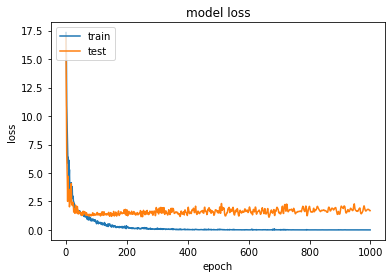

In [63]:
# Loss 
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

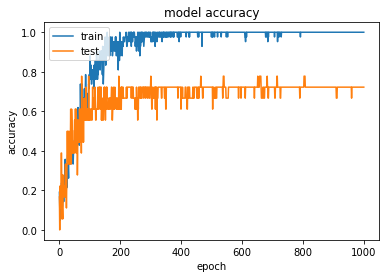

In [64]:
## This is for Accuracy
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [65]:
predictions = model.predict_classes(x_testcnn)

In [66]:
predictions

array([5, 3, 5, 5, 2, 5, 1, 3, 0, 7, 3, 1, 7, 3, 4, 1, 2, 3], dtype=int64)

In [67]:
y_test

array([5, 3, 5, 5, 2, 5, 1, 6, 0, 6, 7, 1, 7, 3, 7, 1, 7, 3])

In [68]:
new_Ytest = y_test.astype(int)

In [69]:
new_Ytest

array([5, 3, 5, 5, 2, 5, 1, 6, 0, 6, 7, 1, 7, 3, 7, 1, 7, 3])

In [70]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         3
           2       0.50      1.00      0.67         1
           3       0.60      1.00      0.75         3
           4       0.00      0.00      0.00         0
           5       1.00      1.00      1.00         4
           6       0.00      0.00      0.00         2
           7       0.50      0.25      0.33         4

    accuracy                           0.72        18
   macro avg       0.57      0.66      0.59        18
weighted avg       0.68      0.72      0.68        18



C:\Users\Siddhant Mulajkar\Anaconda3\envs\sid\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Siddhant Mulajkar\Anaconda3\envs\sid\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [71]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

[[1 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 4 0 0]
 [0 0 0 1 0 0 0 1]
 [0 0 1 1 1 0 0 1]]


In [72]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = 'E:\\8th sem\\Final_Year_Project_Files\\Saved_Models\\'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at E:\8th sem\Final_Year_Project_Files\Saved_Models\Emotion_Voice_Detection_Model.h5 


In [73]:
from tensorflow import keras

from tensorflow.keras.models import load_model

from tensorflow.keras.utils import CustomObjectScope

from tensorflow.keras.initializers import glorot_uniform

with CustomObjectScope({'GlorotUniform': glorot_uniform()}):

    loaded_model = load_model('E:\\8th sem\\Final_Year_Project_Files\\Saved_Models\\Emotion_Voice_Detection_Model.h5')
    loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
activation_3 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_4 (Activation)    (None, 5, 128)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 128)           

In [74]:
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

18/1 [============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 5ms/sample - loss: 1.6930 - accuracy: 0.7222
Restored model, accuracy: 72.22%
